In [1]:
import glob
import cv2
import math 
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import json
import datetime
import matplotlib.image as mpimg
import random
import time


%matplotlib inline
import pandas as pd
import numpy as np
np.random.bit_generator = np.random._bit_generator

from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten,MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model,load_model
#from keras_segmentation.models.model_utils import get_segmentation_mode
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.contrib import distributions

# from tensorflow.keras.utils import np_utils
from skimage.transform import resize
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [2]:
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [3]:
def get_img_name(path):
    names = glob.glob(f"{path}*")
    names.sort()
    return names

def img_process(img):
    img = cv2.resize(img, (IMG_WIDTH,IMG_HEIGHT)) #640x480, 320x240
    return img

def show_seg_on_img(img, mask, alpha=0.5):
    #img = img.astype(np.float64)*255
    #img = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    #mask = mask.astype(np.float64)*255
    #mask = cv2.normalize(mask, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    
    img_mask = cv2.addWeighted(mask, alpha, img, 0.5, 0)
    return img_mask 

def compare_img(img1, img2, title1 = 'Image 1', title2 = 'Image 2'):
    #img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    #img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    fig = plt.figure(figsize=(16, 12))
    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(img1)
    a.set_title(title1)

    a = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(img2)

    
def predictions_and_uncetrenty(model, T, img):
    
    # shape: (T, (H, W), C)
    predictions = np.array([model.predict(img) for _ in range(T)])
    
    # shape: ((H, W), C)
    prediction_probabilities = np.mean(predictions, axis=tuple(range(img.ndim-2)))
   
    # shape: (H, W)
    #prediction_variances = np.apply_along_axis(predictive_entropy, axis=2, arr=prediction_probabilities)
    prediction_std = np.std(predictions, axis=tuple(range(img.ndim-2)))
    prediction_mask = (prediction_probabilities==prediction_probabilities.max(axis=2, keepdims=1)).astype(np.uint8)
    prediction_std = prediction_std * prediction_mask
    prediction_std = np.amax(prediction_std, axis=2)
    
    prediction_mean = prediction_probabilities * prediction_mask
    prediction_mean = np.amax(prediction_mean, axis=2)
    return prediction_mask, prediction_mean ,prediction_std

'''
If we are not using image augmentation we need to reduce the channels.
'''
def labels_to_maskes_reduce(img_label, color_id_map, num_channels):
    num_objects = len(color_id_map.keys())
    
    height = img_label.shape[0]
    width = img_label.shape[1]

    channels = np.zeros((height, width, num_channels), dtype=np.uint8)
    
    for key, value in color_id_map.items():
        mask = (img_label == value[1]).all(-1)

        channels[..., value[0]] = np.logical_or(channels[:,:, value[0]], mask)


    return channels

def maskes_to_labels(maskes):
    #denne maa muligens fjernes
    maskes = (maskes==maskes.max(axis=2, keepdims=1)).astype(np.uint8)
    labels = np.zeros((maskes.shape[0], maskes.shape[1], 3), dtype=np.uint8)
        
    for key, value in classes_cc.items():
        mask = maskes[..., key]
        labels = labels + mask[..., None] * value
    
    return labels 

def predictions_and_uncetrenty(model, T, img):
    
    # shape: (T, (H, W), C)
    predictions = np.array([model.predict(img) for _ in range(T)])
    
    # shape: ((H, W), C)
    prediction_probabilities = np.mean(predictions, axis=tuple(range(img.ndim-2)))
   
    # shape: (H, W)
    #prediction_variances = np.apply_along_axis(predictive_entropy, axis=2, arr=prediction_probabilities)
    prediction_std = np.std(predictions, axis=tuple(range(img.ndim-2)))
    prediction_mask = (prediction_probabilities==prediction_probabilities.max(axis=2, keepdims=1)).astype(np.uint8)
    prediction_std = prediction_std * prediction_mask
    prediction_std = np.amax(prediction_std, axis=2)
    
    prediction_mean = prediction_probabilities * prediction_mask
    prediction_mean = np.amax(prediction_mean, axis=2)
    return prediction_mask, prediction_mean ,prediction_std

In [4]:
def batch_generator(image_paths, label_path, color_labels, index_list, batch_size, index=0):
    
    
    index = index
    label_path_list = label_path
    image_paths_list = image_paths

    while True:
        
        images = []
        #drivable_area = np.array([])#np.ndarray(shape=(IMG_HEIGHT, IMG_WIDTH, NUM_SEG))
        maskes = []
        data_size = len(index_list)
        
        for i in range(batch_size):
            
            #image_id = images_ids.sample()
            
            index += 1
            if index >= data_size:
                index = 0
             
            #index = random.randint(0, data_size)
            img_url = image_paths_list[index_list[index]]
            label_url = label_path_list[index_list[index]]
            
            img = cv2.imread(img_url)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(label_url)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            
            img = img_process(img)
            mask = img_process(mask)

            mask = labels_to_maskes_reduce(mask, color_labels, NUM_SEG)
            
            images.append(img)
            maskes.append(mask) #.tolist()
            #drivable_area = np.append(drivable_area, rb_img, axis=0)

        yield (np.asarray(images), np.asarray(maskes)) # drivable_area

In [5]:
color_label_val = '../data/mapillary-vistas-dataset_public_v1.1/validation/labels/'

image_val = '../data/mapillary-vistas-dataset_public_v1.1/validation/images/'



classes_cc = { #cc = carla cityScape
    0: [0, 0, 0],        # None
    1: [70, 70, 70],     # Buildings
    2: [190, 153, 153],  # Fences
    3: [72, 0, 90],      # Other
    4: [220, 20, 60],    # Pedestrians
    5: [153, 153, 153],  # Poles
    6: [157, 234, 50],   # RoadLines
    7: [128, 64, 128],   # Roads
    8: [244, 35, 232],   # Sidewalks
    9: [107, 142, 35],   # Vegetation
    10: [0, 0, 255],     # Vehicles
    11: [102, 102, 156], # Walls
    12: [220, 220, 0]    # TrafficSigns
}

#Create dictonary for id to new id, add color for each id later. 
color_id_map = {
       0: [3], 
       1: [3], 
       2: [8],
       3: [2],
       4: [2],
       5: [3],
       6: [11],
       7: [8], 
       8: [7], 
       9: [8],
       10: [7], 
       11: [8], 
       12: [0], 
       13: [7],
       14: [7], 
       15: [8],
       16: [0], 
       17: [1],
       18: [0], 
       19: [4],
       20: [4],
       21: [10],
       22: [10],
       23: [6],
       24: [6],
       25: [0],
       26: [0],
       27: [0], 
       28: [0], 
       29: [0], 
       30: [9],
       31: [0], 
       32: [3],
       33: [3],
       34: [3],
       35: [3],
       36: [3],
       37: [3],
       38: [3],
       39: [3],
       40: [3],
       41: [7],
       42: [3],
       43: [7],
       44: [5],
       45: [5],
       46: [12],
       47: [5],
       48: [12],
       49: [12],
       50: [12],
       51: [3],
       52: [3],
       53: [3],
       54: [10],
       55: [10],
       56: [10],
       57: [10],
       58: [0], 
       59: [10],
       60: [10],
       61: [10],
       62: [10],
       63: [0],
       64: [0],
       65: [0],        
    }

# read in config file
with open('../data/mapillary-vistas-dataset_public_v1.1/config.json') as config_file:
    config = json.load(config_file)
# in this example we are only interested in the labels
labels = config['labels']

# print labels
print("There are {} labels in the config file".format(len(labels)))
for label_id, label in enumerate(labels):
    color_id_map[label_id].append(label["color"])
    #print("{:>30} ({:2d}): {:<40} has instances: {}".format(label["readable"], label_id, label["name"], label["instances"]))
        

IMG_HEIGHT = 480 #640x480, 320x240, 160x120
IMG_WIDTH = 640
NUM_SEG = 13

color_label_val_list = get_img_name(color_label_val)
img_val_list = get_img_name(image_val)
print(len(color_label_val_list))
print(len(img_val_list))
#_drivable_id.png
#_drivable_color.png

There are 66 labels in the config file
2000
2000


In [6]:
imges, labels = next(batch_generator(img_val_list, color_label_val_list, color_id_map, [30], 1))
label = maskes_to_labels(labels[0]).astype(np.uint8)
img = imges[0]

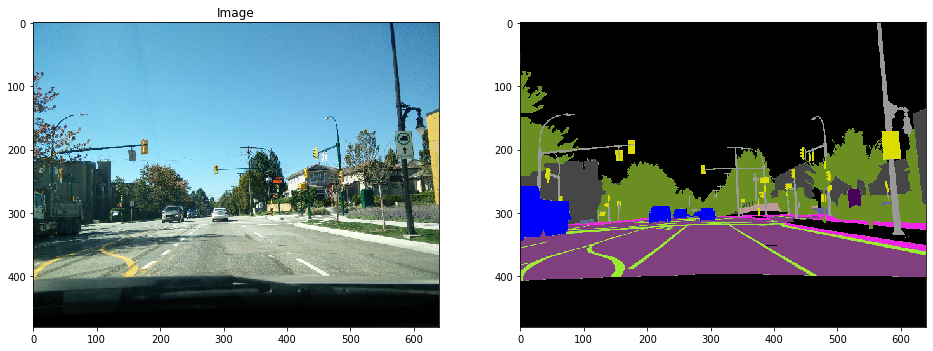

In [7]:
compare_img(img, label, 'Image', 'CityScape labels')


In [8]:
"""
    if True:
        random.seed(0)
        optimizer = Adam(lr=1e-3)
        data_amount = 200
        dropuout_test += 0.05

    with open(json_file_name, "w") as file_write:
    # write json data into file
        json.dump(model_data, file_write)
    file_write.close() 



"""

'\n    if True:\n        random.seed(0)\n        optimizer = Adam(lr=1e-3)\n        data_amount = 200\n        dropuout_test += 0.05\n\n    with open(json_file_name, "w") as file_write:\n    # write json data into file\n        json.dump(model_data, file_write)\n    file_write.close() \n\n\n\n'

In [14]:
with open('model_info_dropout_2.json') as a:
    model_info = json.load(a)

dropout_list = []
dropout = 0.0
for key, value in model_info.items():
    print(f'Key: {key}, dropout rate: {value["dropout"]}')
    dropout_list.append(value["dropout"])
    
    
    #value["architecture"] = "u-net"
    #value["data_amount"] = 200
    #dropout += 0.05



Key: u-net_1585409555, dropout rate: 0.0
Key: u-net_1585411244, dropout rate: 0.05
Key: u-net_1585416117, dropout rate: 0.1
Key: u-net_1585420999, dropout rate: 0.15000000000000002
Key: u-net_1585430092, dropout rate: 0.2
Key: u-net_1585434309, dropout rate: 0.25
Key: u-net_1585441563, dropout rate: 0.3
Key: u-net_1585447817, dropout rate: 0.35
Key: u-net_1585455751, dropout rate: 0.39999999999999997
Key: u-net_1585465530, dropout rate: 0.44999999999999996
Key: u-net_1585472786, dropout rate: 0.49999999999999994


In [10]:
model = load_model(f'seg_models_dropout_2/u-net_1585409555.h5')

def test_single_model(model, index_list, round_nr=0):
    mean_predictions = 0
    std_predictions = 0
    
    batch_g = batch_generator(img_val_list, color_label_val_list, color_id_map, index_list, 1)
    
    for i in range(len(index_list)):
        imges, _ = next(batch_g)
        _, predicted_mean, prediction_std = predictions_and_uncetrenty(model, 20, imges)
        mean_predictions += predicted_mean.mean()
        std_predictions += prediction_std.mean()
        
        #if i % 10 == 0:
         #   print(f'valdata: {i} of {len(index_list)}. Round: {round_nr}')
    
    mean = mean_predictions / len(index_list)
    std = std_predictions / len(index_list)
    return mean, std

data_index = range(200, 400)
#print(test_single_model(model, data_index))


In [11]:
#model = load_model('seg_models_dropout/u-net_small_1585336074.h5')
mean_list = []
std_list = []
round_nr = 0

for key, value in model_info.items():
    round_nr += 1
    print(f'Round nummber: {round_nr}')
    model = load_model(f'seg_models_dropout_2/{key}.h5')
    
    #imges, _ = next(batch_generator(img_val_list, color_label_val_list, color_id_map, [0], 1))
    #predicted_target, predicted_mean, prediction_std = predictions_and_uncetrenty(model, 10, imges)
    
    #mean = predicted_mean.mean()
    #std = prediction_std.mean()
    mean, std = test_single_model(model, data_index)
    mean_list.append(mean)
    std_list.append(std)
    
    print(f'Dropout rate: {value["dropout"]}, mean: {mean}, std: {std}')

Round nummber: 1
Dropout rate: 0.0, mean: 0.5292403090000153, std: 5.5501646940570024e-08
Round nummber: 2
Dropout rate: 0.05, mean: 0.6948914968967438, std: 0.03575329970102757
Round nummber: 3
Dropout rate: 0.1, mean: 0.6587716996669769, std: 0.04750951963476837
Round nummber: 4
Dropout rate: 0.15000000000000002, mean: 0.7109411858022213, std: 0.0689681200683117
Round nummber: 5
Dropout rate: 0.2, mean: 0.685439582914114, std: 0.05920748307369649
Round nummber: 6
Dropout rate: 0.25, mean: 0.6882922504842282, std: 0.07597915909253061
Round nummber: 7
Dropout rate: 0.3, mean: 0.6743168325722217, std: 0.07520214354619384
Round nummber: 8
Dropout rate: 0.35, mean: 0.6661979840695857, std: 0.08151352418586612
Round nummber: 9
Dropout rate: 0.39999999999999997, mean: 0.7147975735366344, std: 0.08143742382526398
Round nummber: 10
Dropout rate: 0.44999999999999996, mean: 0.6377666607499123, std: 0.08993663655593992
Round nummber: 11
Dropout rate: 0.49999999999999994, mean: 0.6689392878115177

In [12]:
#with open('model_info_dropout.json', "w") as file_write:
#    # write json data into file
#    json.dump(model_info, file_write)
#    file_write.close() 



Dropout rate: 0.0, mean: 0.5906203985214233, std: 4.0500773934581957e-07

Dropout rate: 0.05, mean: 0.7329370975494385, std: 0.03791151940822601

Dropout rate: 0.1, mean: 0.6642459630966187, std: 0.046381644904613495

Dropout rate: 0.15000000000000002, mean: 0.7706935405731201, std: 0.064803346991539

Dropout rate: 0.2, mean: 0.6317365765571594, std: 0.07258059084415436

Dropout rate: 0.25, mean: 0.5880712270736694, std: 0.08099215477705002

Dropout rate: 0.3, mean: 0.7194401025772095, std: 0.07579252123832703

Dropout rate: 0.35, mean: 0.7389044761657715, std: 0.0762946680188179

Dropout rate: 0.39999999999999997, mean: 0.4845237135887146, std: 0.09026665985584259

Dropout rate: 0.44999999999999996, mean: 0.6494069695472717, std: 0.08584124594926834

Dropout rate: 0.49999999999999994, mean: 0.7205850481987, std: 0.083424873650074

Dropout rate: 0.0, mean: 0.5292403090000153, std: 5.5501646940570024e-08

Dropout rate: 0.05, mean: 0.6948914968967438, std: 0.03575329970102757

Dropout rate: 0.1, mean: 0.6587716996669769, std: 0.04750951963476837

Dropout rate: 0.15000000000000002, mean: 0.7109411858022213, std: 0.0689681200683117

Dropout rate: 0.2, mean: 0.685439582914114, std: 0.05920748307369649

Dropout rate: 0.25, mean: 0.6882922504842282, std: 0.07597915909253061

Dropout rate: 0.3, mean: 0.6743168325722217, std: 0.07520214354619384

Dropout rate: 0.35, mean: 0.6661979840695857, std: 0.08151352418586612

Dropout rate: 0.39999999999999997, mean: 0.7147975735366344, std: 0.08143742382526398

Dropout rate: 0.44999999999999996, mean: 0.6377666607499123, std: 0.08993663655593992

Dropout rate: 0.49999999999999994, mean: 0.6689392878115177, std: 0.09365229136310518

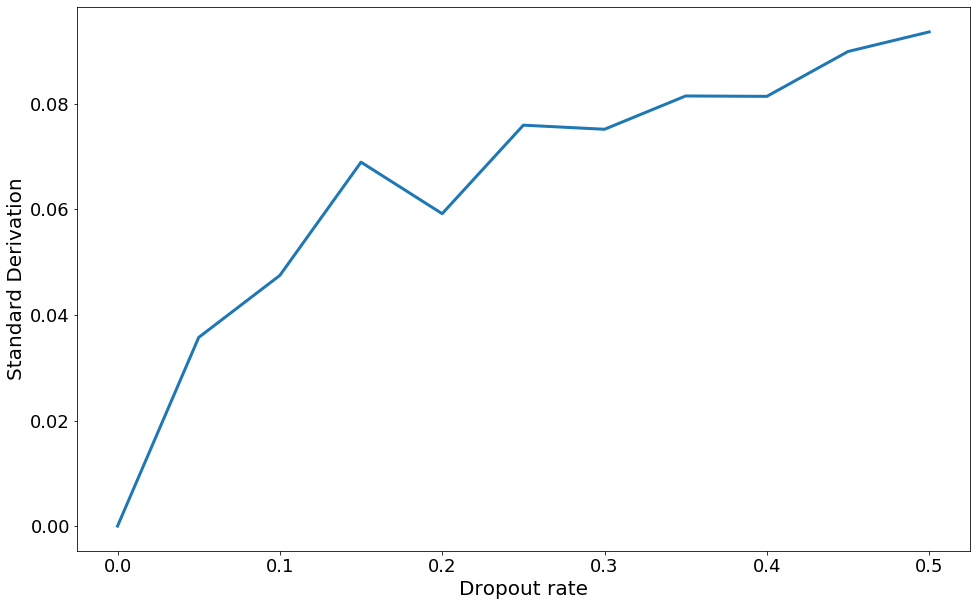

In [35]:
plt.figure(figsize=(16, 10))

plt.xlabel('Dropout rate', fontsize=20)
plt.ylabel('Standard Derivation', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.plot(dropout_list, std_list, linewidth=3)

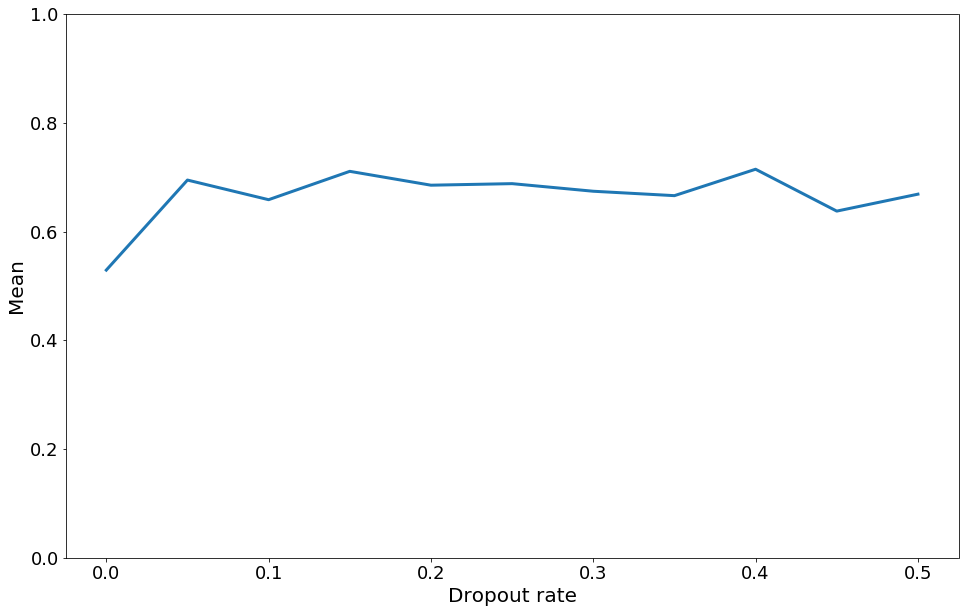

In [36]:
y_akses_list = []
counter = 0

for _ in range(11):
    y_akses_list.append(counter)
    counter += 0.05
plt.figure(figsize=(16, 10))
#plt.bar(, y_akses_list)
plt.ylim(0,1)
plt.xlabel('Dropout rate', fontsize=20)
plt.ylabel('Mean', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.plot(dropout_list, mean_list, linewidth=3)